In [ ]:
# !pip install --upgrade scipy

In [ ]:
# !pip install opencv-python

In [ ]:
# !pip install imgaug

In [ ]:
import scipy
from scipy import io
import imageio
import cv2
import pandas as pd
import os
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import re

In [ ]:
def extract_mat_contents(annot_directory, image_dir):
    mat = scipy.io.loadmat(annot_directory)
    height, width = cv2.imread(image_dir).shape[:2]
    x1, y2, y1, x2 = tuple(map(tuple, mat['box_coord']))[0]
    class_name = image_dir.split('\\')[1]
    filename = '\\'.join(image_dir.split('\\')[-2:])
    return filename,  width, height, class_name, x1,y1,x2,y2

In [ ]:

# Function to convert MAT files to CSV
def mat_to_csv(annot_directory, image_directory, classes_folders):
    mat_list = []
    for class_folder in classes_folders:
        image_dir = os.path.join(image_directory, class_folder)
        annot_dir = os.path.join(annot_directory, class_folder)
        mat_files = sorted(os.listdir(annot_dir))
        img_files = sorted(os.listdir(image_dir))
        for mat, image_file in zip(mat_files, img_files):
            mat_path = os.path.join(annot_dir, mat)
            img_path = os.path.join(image_dir, image_file)
            value = extract_mat_contents(mat_path, img_path)
            mat_list.append(value)
    column_name = ["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"]
    mat_df = pd.DataFrame(mat_list, columns=column_name)
    return mat_df


In [ ]:

# The Classes we will use for our training
# classes_list = sorted(['airplanes', 'ant'])
classes_list = sorted(['butterfly',  'cougar_face', 'elephant'])


# Set our images and annotations directory
image_directory = '101_ObjectCategories'
annot_directory = 'Annotations'

# Run the function to convert all the MAT files to a Pandas DataFrame
labels_df = mat_to_csv(annot_directory, image_directory, classes_list)

# Saving the Pandas DataFrame as CSV File
labels_df.to_csv(('labels.csv'), index=None)

In [ ]:
mat_list = []
for class_folder in classes_list:
    image_dir = os.path.join(image_directory, class_folder)
    annot_dir = os.path.join(annot_directory, class_folder)
    mat_files = sorted(os.listdir(annot_dir))
    img_files = sorted(os.listdir(image_dir))
    for mat, image_file in zip(mat_files, img_files):
        mat_path = os.path.join(annot_dir, mat)
        img_path = os.path.join(image_dir, image_file)
        value = extract_mat_contents(mat_path, img_path)
        mat_list.append(value)
column_name = ["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"]
mat_df = pd.DataFrame(mat_list, columns=column_name)


In [ ]:
# Function to convert bounding box image into DataFrame 
def bounding_boxes_to_df(bounding_boxes_object):

    # Convert Bounding Boxes Object to Array
    bounding_boxes_array = bounding_boxes_object.to_xyxy_array()
    
    # Convert the array into DataFrame
    df_bounding_boxes = pd.DataFrame(bounding_boxes_array,columns=['xmin', 'ymin', 'xmax', 'ymax'])
    
    # Return the DataFrame
    return df_bounding_boxes

In [ ]:
from imgaug import augmenters as iaa

In [ ]:
# Define all the Augmentations you want to apply to your dataset
# We're setting random `n` agumentations to 2. 
image_augmentations = iaa.SomeOf( 2,
    [                                 
    # Scale the Images
    iaa.Affine(scale=(0.5, 1.5)),

    # Rotate the Images
    iaa.Affine(rotate=(-60, 60)),

    # Shift the Image
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),

    # Flip the Image
    iaa.Fliplr(1),

    # Increase or decrease the brightness
    iaa.Multiply((0.5, 1.5)),

    # Add Gaussian Blur
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    
    # Add Gaussian Noise
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))

])

In [ ]:
labels_df

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
for i in range(100):
    img = imageio.imread(os.path.join('101_ObjectCategories', labels_df.iloc[i,0]))

    left, top, right, bottom = labels_df[['xmin', 'ymin', 'xmax', 'ymax']].iloc[i]
    width = right - left
    height = bottom - top
    fig, ax = plt.subplots()
    ax.imshow(img)
    rect = patches.Rectangle((left, top), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [ ]:
img = imageio.imread(labels_df.iloc[0,0])
plt.imshow(img)

In [ ]:
def image_aug(df, images_path, aug_images_path, augmentor, multiple=3):
    augmentations_df = pd.DataFrame(columns=["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"])
    grouped_df = df.groupby("filename")
    if not os.path.exists(aug_images_path):
        os.mkdir(aug_images_path)
    for folder in df["class"].unique():
        if not os.path.exists(os.path.join(aug_images_path, folder)):
            os.mkdir(os.path.join(aug_images_path, folder))
    for i in range(multiple):
        image_postfix = str(i)
        for filename in df["filename"].unique():
            augmented_path = os.path.join(aug_images_path, filename) + image_postfix + ".jpg"
            single_image = grouped_df.get_group(filename)
            single_image = single_image.reset_index()
            single_image = single_image.drop(["index"], axis=1)
            image = imageio.imread(os.path.join(images_path, filename))
            bounding_box_array = single_image.drop(["filename", "width", "height", "class"], axis=1).values
            bounding_box = BoundingBoxesOnImage.from_xyxy_array(bounding_box_array, shape=image.shape)
            image_aug, bounding_box_aug = augmentor(image=image, bounding_boxes=bounding_box)
            bounding_box_aug = bounding_box_aug.remove_out_of_image()
            bounding_box_aug = bounding_box_aug.clip_out_of_image()
            if re.findall("Image...", str(bounding_box_aug)) == ["Image([]"]:
                pass
            else:
                imageio.imwrite(augmented_path, image_aug)
                info_df = single_image.drop(["xmin", "ymin", "xmax", "ymax"], axis=1)
                for index, _ in info_df.iterrows():
                    info_df.at[index, "width"] = image_aug.shape[1]
                    info_df.at[index, "height"] = image_aug.shape[0]
                info_df["filename"] = info_df["filename"].apply(lambda x: x + image_postfix + ".jpg")
                bounding_box_df = bounding_boxes_to_df(bounding_box_aug)
                aug_df = pd.concat([info_df, bounding_box_df], axis=1)
                augmentations_df = pd.concat([augmentations_df, aug_df])
    augmentations_df = augmentations_df.reset_index()
    augmentations_df = augmentations_df.drop(["index"], axis=1)
    return augmentations_df
augmented_images_df = image_aug(labels_df, image_directory, "aug_images", image_augmentations)

In [ ]:
augmented_images_df = augmented_images_df.sort_values('filename', ignore_index= True)
augmented_images_df.to_csv('aug.csv')

# Check Dataset Size
print('Our total dataset Size before the augmentations was: ', len(labels_df))
print('Our total dataset Size after the augmentations is: ', len(augmented_images_df))

In [ ]:
augmented_images_df

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))
x = np.arange(2000)/100
sales_scale = 1e9
spend_scale = 1e5
norm_factor = sales_scale / spend_scale
y = (sigmoid(x**.5) +  x/40) / norm_factor

In [85]:
1

1

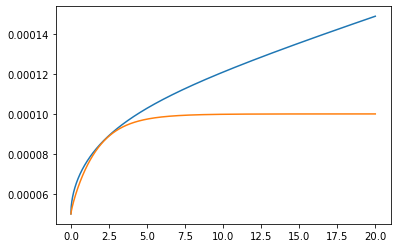

In [86]:
plt.plot(x, y)
y = sigmoid(x**.8) / norm_factor
plt.plot(x, y)
plt.show()